In [1]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from tqdm import trange
%matplotlib inline

In [3]:
env = gym.make('LunarLander-v2')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


In [4]:
from DQN_agentv2 import Agent
import time
agent = Agent(state_size=8, action_size=4, seed=0)
n_ep_running_average = 50   

In [5]:
def running_average(x, N):
    ''' Function used to compute the running average
        of the last N elements of a vector x
    '''
    if len(x) >= N:
        y = np.copy(x)
        y[N-1:] = np.convolve(x, np.ones((N, )) / N, mode='valid')
    else:
        y = np.zeros_like(x)
    return y

In [34]:
n_episodes=60
max_t=1000
eps_start=1.0
eps_end=0.01
eps_decay=0.995


eps = eps_start                    # initialize epsilon
episode_reward_list = []       # this list contains the total reward per episode
episode_number_of_steps = []   # this list contains the number of steps per episode
EPISODES = trange(n_episodes, desc='Episode: ', leave=True)
for i in EPISODES:
    state = env.reset()
    score = 0
    total_episode_reward = 0.
    t=0
    for k in range(max_t):
        action = agent.act(state, eps)
        #env.render()
        next_state, reward, done, _ = env.step(action)
        total_episode_reward += reward
        agent.step(state, action, reward, next_state, done)
        state = next_state
        t+=1
        if done:
            break 

    episode_reward_list.append(total_episode_reward)
    episode_number_of_steps.append(t)
    eps = max(eps_end, eps_decay*eps) # decrease epsilon
    EPISODES.set_description("Episode {} - Reward/Steps: {:.1f}/{} - Avg. Reward/Steps: {:.1f}/{}".format(i, total_episode_reward, t,
    running_average(episode_reward_list, n_ep_running_average)[-1],
    running_average(episode_number_of_steps, n_ep_running_average)[-1]))

    if running_average(episode_number_of_steps, n_ep_running_average)[-1]>=200.0:
        print('\nEnvironment solved')
        torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth') 
        break
    





Episode 0 - Reward/Steps: -175.0/86 - Avg. Reward/Steps: 0.0/0:   0%|          | 0/60 [00:00<?, ?it/s]
Environment solved



In [30]:
len(episode_number_of_steps)

60

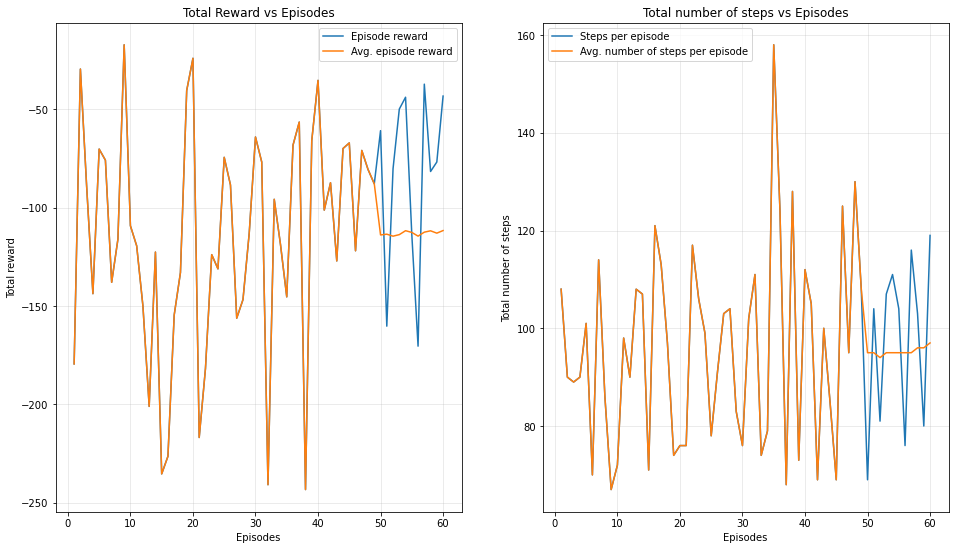

In [33]:

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
ax[0].plot([i for i in range(1, n_episodes+1)], episode_reward_list, label='Episode reward')
ax[0].plot([i for i in range(1, n_episodes+1)], running_average(
    episode_reward_list, n_ep_running_average), label='Avg. episode reward')
ax[0].set_xlabel('Episodes')
ax[0].set_ylabel('Total reward')
ax[0].set_title('Total Reward vs Episodes')
ax[0].legend()
ax[0].grid(alpha=0.3)

ax[1].plot([i for i in range(1, n_episodes+1)], episode_number_of_steps, label='Steps per episode')
ax[1].plot([i for i in range(1, n_episodes+1)], running_average(
    episode_number_of_steps, n_ep_running_average), label='Avg. number of steps per episode')
ax[1].set_xlabel('Episodes')
ax[1].set_ylabel('Total number of steps')
ax[1].set_title('Total number of steps vs Episodes')
ax[1].legend()
ax[1].grid(alpha=0.3)
plt.show()

In [36]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(5):
    state = env.reset()
    for j in range(300):
        action = agent.act(state)
        env.render()
        time.sleep(0.0125)
        state, reward, done, _ = env.step(action)
        if done:
            break     
env.close()

KeyboardInterrupt: 

In [37]:
N_EPISODES = 50            
CONFIDENCE_PASS = 50
episode_reward_list = [] 
print('Checking solution...')
EPISODES = trange(N_EPISODES, desc='Episode: ', leave=True)

for i in EPISODES:
    EPISODES.set_description("Episode {}".format(i))
    done = False
    state = env.reset()
    total_episode_reward = 0.
    while not done:
        q_values = agent.qnetwork_local(torch.tensor([state]))
        _, action = torch.max(q_values, axis=1)
        next_state, reward, done, _ = env.step(action.item())
        total_episode_reward += reward
        state = next_state
    episode_reward_list.append(total_episode_reward)
    env.close()

avg_reward = np.mean(episode_reward_list)
confidence = np.std(episode_reward_list) * 1.96 / np.sqrt(N_EPISODES)
print('Policy achieves an average total reward of {:.1f} +/- {:.1f} with confidence 95%.'.format(avg_reward,confidence))
if avg_reward - confidence >= CONFIDENCE_PASS:
    print('Your policy passed the test!')
else:
    print("Your policy did not pass the test! The average reward of your policy needs to be greater than {} with 95% confidence".format(CONFIDENCE_PASS))

Episode 49: 100%|██████████| 50/50 [01:16<00:00,  1.52s/it]Policy achieves an average total reward of 17.4 +/- 17.6 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than 50 with 95% confidence

